<a href="https://colab.research.google.com/github/Space-Xplorer/Space-Xplorer/blob/main/CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow keras numpy pandas matplotlib


In [2]:
!pip install kaggle

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("huanranye/inria-aerial-image-labeling-dataset")

print("Path to dataset files:", path)

100%|██████████| 13.7G/13.7G [02:54<00:00, 84.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/huanranye/inria-aerial-image-labeling-dataset/versions/1


In [21]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define image size
IMG_SIZE = (128, 128)

# Base directory containing subdirectories
base_dir = '/root/.cache/kagglehub/datasets/huanranye/inria-aerial-image-labeling-dataset/versions/1/cropped_1024'

def load_images_and_masks(base_dir):
    images = []
    masks = []

    for root, dirs, files in os.walk(base_dir):
        if "images" in root:  # Image directory
            for file in files:
                img_path = os.path.join(root, file)
                mask_path = img_path.replace("images", "binary_masks").replace(".jpg", ".tif")

                # Load and preprocess image
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, IMG_SIZE)
                    img = img / 255.0  # Normalize to [0, 1]
                    images.append(img)

                # Load and preprocess mask
                if os.path.exists(mask_path):
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
                    mask = cv2.resize(mask, IMG_SIZE)
                    mask = (mask > 0).astype(np.uint8)  # Binary mask
                    masks.append(mask)

    return np.array(images), np.array(masks)

# Load dataset
images, masks = load_images_and_masks(base_dir)

# Ensure masks have the same number of channels
masks = np.expand_dims(masks, axis=-1)

# Split the dataset into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

# Define the U-Net architecture
def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Create the model
model = unet_model()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('model_checkpoint.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_images, train_masks,
    validation_data=(val_images, val_masks),
    batch_size=16,
    epochs=5,
    callbacks=[checkpoint, early_stopping]
)

# Display model summary
model.summary()


Epoch 1/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 3463s 24s/step - accuracy: 0.8130 - loss: 0.5766 - val_accuracy: 0.8589 - val_loss: 0.3375
Epoch 2/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 3393s 24s/step - accuracy: 0.8702 - loss: 0.3062 - val_accuracy: 0.8783 - val_loss: 0.2919
Epoch 3/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 3464s 24s/step - accuracy: 0.8874 - loss: 0.2698 - val_accuracy: 0.8786 - val_loss: 0.2856
Epoch 4/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 3433s 24s/step - accuracy: 0.8906 - loss: 0.2613 - val_accuracy: 0.8977 - val_loss: 0.2609
Epoch 5/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 3416s 24s/step - accuracy: 0.8998 - loss: 0.2413 - val_accuracy: 0.9074 - val_loss: 0.2289


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 128, 128, 64)   │          1,792 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_30[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 64, 64, 64)     │              0 │ conv2d_31[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_32[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 32, 32, 128)    │              0 │ conv2d_33[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_34 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_35 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_34[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 16, 16, 256)    │              0 │ conv2d_35[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_36 (Conv2D)        │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_37 (Conv2D)        │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_36[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_6           │ (None, 32, 32, 512)    │              0 │ conv2d_37[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 32, 32, 768)    │              0 │ up_sampling2d_6[0][0], │
│ (Concatenate)             │                        │                │ conv2d_35[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 32, 32, 256)    │      1,769,728 │ concatenate_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_38[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_7      

 Total params: 23,348,741 (89.07 MB)

 Trainable params: 7,782,913 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,565,828 (59.38 MB)

23-11-2024 00:00Hrs

In [22]:
# Evaluate on validation/test set
loss, accuracy = model.evaluate(val_images, val_masks)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 234s 13s/step - accuracy: 0.9078 - loss: 0.2265
Validation Loss: 0.22893285751342773
Validation Accuracy: 0.9074187874794006


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step


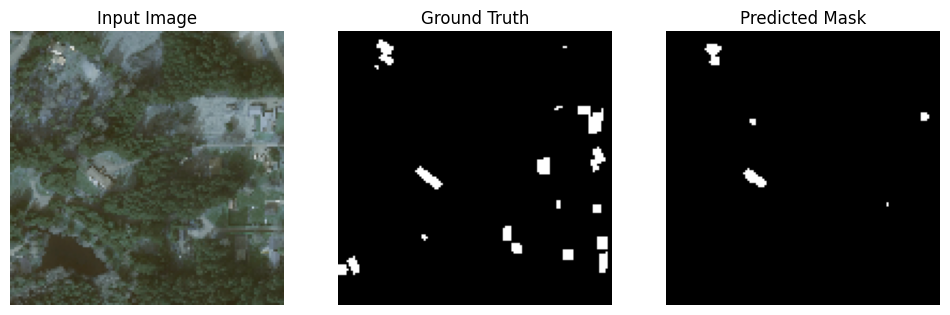

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


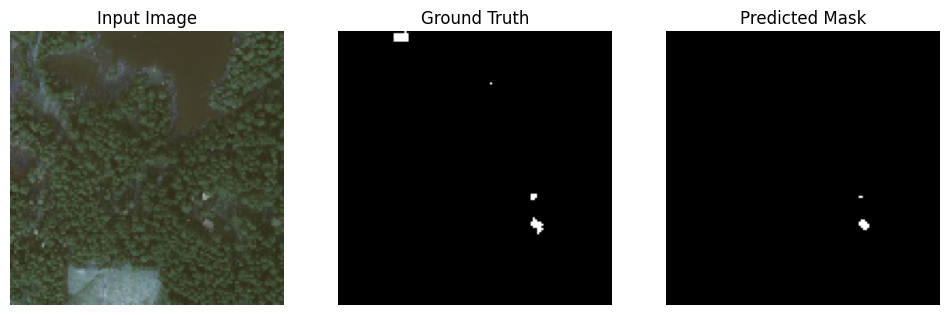

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


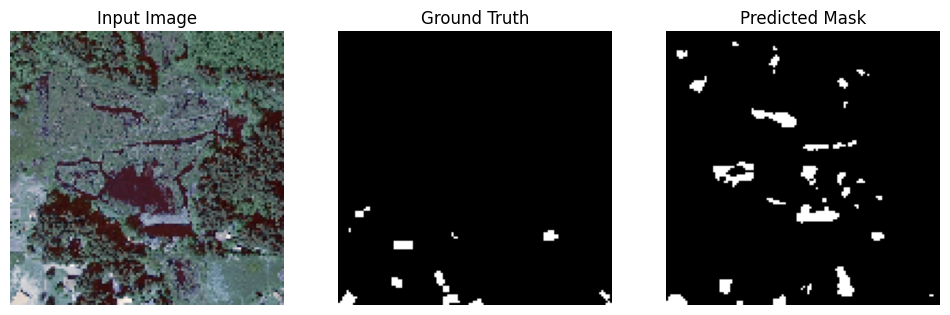

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


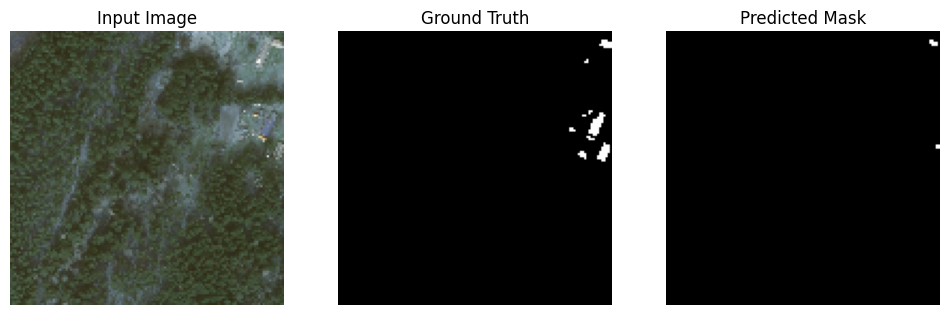

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


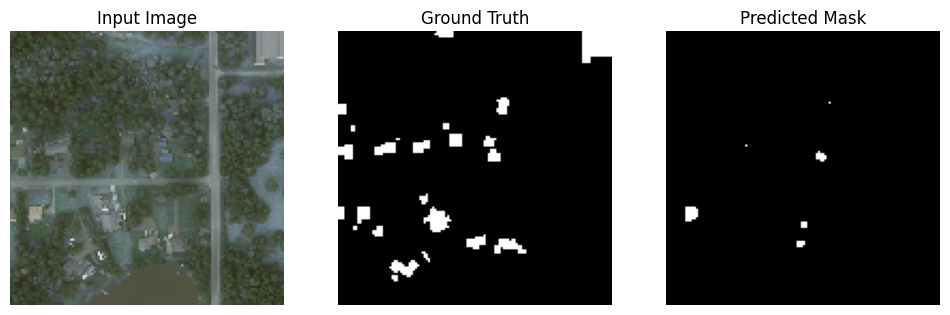

In [23]:
import matplotlib.pyplot as plt

# Choose a few random samples
for i in range(5):
    index = np.random.randint(0, len(val_images))
    input_image = val_images[index]
    ground_truth = val_masks[index]

    # Predict the mask
    predicted_mask = model.predict(np.expand_dims(input_image, axis=0))[0]
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Thresholding for binary mask

    # Plot the input image, ground truth, and predicted mask
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(input_image)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(ground_truth, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask, cmap="gray")
    plt.axis("off")
    plt.show()

In [24]:
model.save('final_unet_model.keras')